In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from math import cos, sin

import numpy as np

from fastai.column_data import *
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
from models import *
from utils import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
ls -f KITTI/ | grep .csv

validation.csv
validation_192_640.csv
training.csv
validation_192_640_pre.csv
training_192_640_pre.csv
training_192_640.csv


In [5]:
ls KITTI/2011_10_03/2011_10_03_drive_0034_sync/image_03/data/0000003783.png

KITTI/2011_10_03/2011_10_03_drive_0034_sync/image_03/data/0000003783.png


train, val= pd.read_csv('./KITTI/training.csv'), pd.read_csv('./KITTI/validation.csv')

In [6]:
train, val= pd.read_csv('./KITTI/training_192_640_pre.csv'), pd.read_csv('./KITTI/validation_192_640_pre.csv')

In [7]:
for i in range(3):
    train = train.sample(frac=1)
    

train.reset_index(drop=True, inplace=True)

In [8]:
for i in range(3):
    val = val.sample(frac=1)

val.reset_index(drop=True, inplace=True);

In [9]:
train.head()

,t0,t1,t2,fx,fy,cx,cy
0,2011_09_30/2011_09_30_drive_0027_sync/image_02...,2011_09_30/2011_09_30_drive_0027_sync/image_02...,2011_09_30/2011_09_30_drive_0027_sync/image_02...,364.362615,362.030694,310.151266,93.752525
1,2011_09_29/2011_09_29_drive_0004_sync/image_03...,2011_09_29/2011_09_29_drive_0004_sync/image_03...,2011_09_29/2011_09_29_drive_0004_sync/image_03...,370.156573,367.787571,309.379246,92.934246
2,2011_10_03/2011_10_03_drive_0027_sync/image_03...,2011_10_03/2011_10_03_drive_0027_sync/image_03...,2011_10_03/2011_10_03_drive_0027_sync/image_03...,370.424992,368.054272,312.885179,94.830438
3,2011_09_26/2011_09_26_drive_0096_sync/image_02...,2011_09_26/2011_09_26_drive_0096_sync/image_02...,2011_09_26/2011_09_26_drive_0096_sync/image_02...,371.806866,369.427302,314.104631,88.501248
4,2011_10_03/2011_10_03_drive_0042_sync/image_02...,2011_10_03/2011_10_03_drive_0042_sync/image_02...,2011_10_03/2011_10_03_drive_0042_sync/image_02...,370.424992,368.054272,312.885179,94.830438


In [10]:
val.head()

,t0,t1,t2,fx,fy,cx,cy
0,2011_09_26/2011_09_26_drive_0027_sync/image_03...,2011_09_26/2011_09_26_drive_0027_sync/image_03...,2011_09_26/2011_09_26_drive_0027_sync/image_03...,371.806866,369.427302,314.104631,88.501248
1,2011_10_03/2011_10_03_drive_0034_sync/image_02...,2011_10_03/2011_10_03_drive_0034_sync/image_02...,2011_10_03/2011_10_03_drive_0034_sync/image_02...,370.424992,368.054272,312.885179,94.830438
2,2011_10_03/2011_10_03_drive_0034_sync/image_03...,2011_10_03/2011_10_03_drive_0034_sync/image_03...,2011_10_03/2011_10_03_drive_0034_sync/image_03...,370.424992,368.054272,312.885179,94.830438
3,2011_09_26/2011_09_26_drive_0101_sync/image_03...,2011_09_26/2011_09_26_drive_0101_sync/image_03...,2011_09_26/2011_09_26_drive_0101_sync/image_03...,371.806866,369.427302,314.104631,88.501248
4,2011_09_26/2011_09_26_drive_0023_sync/image_02...,2011_09_26/2011_09_26_drive_0023_sync/image_02...,2011_09_26/2011_09_26_drive_0023_sync/image_02...,371.806866,369.427302,314.104631,88.501248


In [11]:
trn0, trn1, trn2, trn_camera = train.t0, train.t1,train.t2, train[['fx', 'fy', 'cx', 'cy']]

In [12]:
val0, val1, val2, val_camera  = val.t0, val.t1, val.t2, val[['fx', 'fy', 'cx', 'cy']]

In [13]:
trn_camera.head()

,fx,fy,cx,cy
0,364.362615,362.030694,310.151266,93.752525
1,370.156573,367.787571,309.379246,92.934246
2,370.424992,368.054272,312.885179,94.830438
3,371.806866,369.427302,314.104631,88.501248
4,370.424992,368.054272,312.885179,94.830438


val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

aug_tfms = [
    #RandomDihedral(tfm_y=TfmType.NO),
    RandomLighting(b=0.05, c=0.05)]

In [14]:
arch = f
scale,bs = 1, 8
#scale,bs = 4, 32
sz = None #np.array([345, 1242]) 
sz_y = None 

DPATH = "KITTI/"
PATH = 'Fastai_TRN'

class UnsupFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        super().__init__(fnames, transform, path)
    def get_y(self, i): return None
    def get_c(self): return 0

class UnShuffleImageData(ImageData):
    def __init__(self, path, datasets, bs, num_workers, classes):
        trn_ds,val_ds,fix_ds,aug_ds,test_ds,test_aug_ds = datasets
        self.path,self.bs,self.num_workers,self.classes = path,bs,num_workers,classes
        self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl,self.test_dl,self.test_aug_dl = [
            self.get_dl(ds,shuf) for ds,shuf in [
                (trn_ds,False),(val_ds,False),(fix_ds,False),(aug_ds,False),
                (test_ds,False),(test_aug_ds,False)
            ]
        ]

class UnScaleTransforms():
    def __init__(self, sz, tfms, normalizer, denorm,
                 tfm_y=TfmType.NO, sz_y=None):
        if sz_y is None: sz_y = sz
        self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        self.tfms = tfms
        if normalizer is not None: self.tfms.append(normalizer)
        self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms)
    def __repr__(self): return str(self.tfms)

# just a little modification which remove the multipler at the batch size of the val DL
class UnDBSColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, is_reg=True, is_multi=False, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs), is_reg=is_reg, is_multi=is_multi) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y, is_reg=is_reg, is_multi=is_multi),
                   PassthruDataset(*(val_xs.T), val_y, is_reg=is_reg, is_multi=is_multi),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs=64, is_reg=True, is_multi=False, test_df=None, shuffle=True):
        trn_ds  = ColumnarDataset.from_data_frame(trn_df,  cat_flds, trn_y, is_reg, is_multi)
        val_ds  = ColumnarDataset.from_data_frame(val_df,  cat_flds, val_y, is_reg, is_multi)
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds, None,  is_reg, is_multi) if test_df is not None else None
        return cls(path, trn_ds, val_ds, bs, test_ds=test_ds, shuffle=shuffle)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs=64, is_reg=True, is_multi=False, test_df=None, shuffle=True):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, is_reg, is_multi, test_df=test_df, shuffle=shuffle)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn, self.is_reg, self.is_multi)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)


class Transforms():
    def __init__(self, sz, tfms, normalizer, denorm, crop_type=CropType.CENTER,
                 tfm_y=TfmType.NO, sz_y=None):
        if sz_y is None: sz_y = sz
        self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        crop_tfm = crop_fn_lu[crop_type](sz, tfm_y, sz_y)
        self.tfms = tfms
        self.tfms.append(crop_tfm)
        if normalizer is not None: self.tfms.append(normalizer)
        self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms)
    def __repr__(self): return str(self.tfms)
    

def image_gen(normalizer, denorm, sz, tfms=None, max_zoom=None, pad=0, crop_type=None,
              tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, scale=None):
    """
    Generate a standard set of transformations

    Arguments
    ---------
     normalizer :
         image normalizing function
     denorm :
         image denormalizing function
     sz :
         size, sz_y = sz if not specified.
     tfms :
         iterable collection of transformation functions
     max_zoom : float,
         maximum zoom
     pad : int,
         padding on top, left, right and bottom
     crop_type :
         crop type
     tfm_y :
         y axis specific transformations
     sz_y :
         y size, height
     pad_mode :
         cv2 padding style: repeat, reflect, etc.

    Returns
    -------
     type : ``Transforms``
         transformer for specified image operations.

    See Also
    --------
     Transforms: the transformer object returned by this function
    """
    if tfm_y is None: tfm_y=TfmType.NO
    if tfms is None: tfms=[]
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    if sz_y is None: sz_y = sz
    if scale is None:
        scale = [RandomScale(sz, max_zoom, tfm_y=tfm_y, sz_y=sz_y) if max_zoom is not None
                 else Scale(sz, tfm_y, sz_y=sz_y)]
    elif not is_listy(scale): scale = [scale]
    if pad: scale.append(AddPadding(pad, mode=pad_mode))
    if crop_type!=CropType.GOOGLENET: tfms=scale+tfms
    return Transforms(sz, tfms, normalizer, denorm, crop_type,
                      tfm_y=tfm_y, sz_y=sz_y)

def noop(x):
    """dummy function for do-nothing.
    equivalent to: lambda x: x"""
    return x

transforms_basic    = [RandomRotate(10), RandomLighting(0.05, 0.05)]
transforms_side_on  = transforms_basic + [RandomFlip()]
transforms_top_down = transforms_basic + [RandomDihedral()]

imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
"""Statistics pertaining to image data from image net. mean and std of the images of each color channel"""
inception_stats = A([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
inception_models = (inception_4, inceptionresnet_2)

def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
    """ Given the statistics of the training image sets, returns separate training and validation transform functions
    """
    if aug_tfms is None: aug_tfms=[]
    tfm_norm = Normalize(*stats, tfm_y=tfm_y if norm_y else TfmType.NO) if stats is not None else None
    tfm_denorm = Denormalize(*stats) if stats is not None else None
    val_crop = CropType.CENTER if crop_type in (CropType.RANDOM,CropType.GOOGLENET) else crop_type
    val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop,
            tfm_y=tfm_y, sz_y=sz_y, scale=scale)
    trn_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=crop_type,
            tfm_y=tfm_y, sz_y=sz_y, tfms=aug_tfms, max_zoom=max_zoom, pad_mode=pad_mode, scale=scale)
    return trn_tfm, val_tfm


def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
    """ Returns separate transformers of images for training and validation.
    Transformers are constructed according to the image statistics given by the model. (See tfms_from_stats)

    Arguments:
        f_model: model, pretrained or not pretrained
    """
    stats = inception_stats if f_model in inception_models else imagenet_stats
    return tfms_from_stats(stats, sz, aug_tfms, max_zoom=max_zoom, pad=pad, crop_type=crop_type,
                           tfm_y=tfm_y, sz_y=sz_y, pad_mode=pad_mode, norm_y=norm_y, scale=scale)


    return Transforms(sz, tfms, normalizer, denorm, crop_type,
                      tfm_y=tfm_y, sz_y=sz_y, )

In [15]:
stats = imagenet_stats # from fastai library
tfm_norm = Normalize(*stats, tfm_y=TfmType.NO) 
tfm_denorm = Denormalize(*stats)

In [16]:
trn_tfms = UnScaleTransforms(sz=None, tfms=[], normalizer=tfm_norm, denorm=tfm_denorm, tfm_y=TfmType.NO, sz_y=sz_y)
val_tfms = UnScaleTransforms(sz=None, tfms=[], normalizer=tfm_norm, denorm=tfm_denorm, tfm_y=TfmType.NO, sz_y=sz_y)

imgnet_mean, imgnet_std = torch.from_numpy(stats[0]).float(), torch.from_numpy(stats[1]).float()
imgnet_mean, imgnet_std = imgnet_mean.view(1,3,1,1), imgnet_std.view(1,3,1,1)

def denorm(imgs, mean, std):
    return V(imgs.cpu().data * std + mean)

def get_MD(trn, val):
    
#     tfms = tfms_from_model(
#         arch,
#         sz,
#         crop_type=CropType.NO,
#         tfm_y=TfmType.NO,
#         aug_tfms=aug_tfms,
#         sz_y=sz_y)

    tfms = (trn_tfms, val_tfms)
    
    datasets = ImageData.get_ds(
        UnsupFilesDataset,
        (trn, None),
        (val, None),
        tfms, path='KITTI/')
    md = UnShuffleImageData(
        PATH,
        datasets,
        bs, num_workers=16,
        classes=None)
    
    return md

def get_cam(trn_cam, val_cam):
    return UnDBSColumnarModelData.from_data_frames(
        path= None,
        trn_df=trn_cam, val_df=val_cam,
        trn_y=None, val_y=None,
        cat_flds=[],
        bs=bs, shuffle=False)

In [17]:
tfms = (trn_tfms, val_tfms)

MD1 = get_MD(trn0, val0, tfms, bs, DPATH, PATH)
MD2 = get_MD(trn1, val1, tfms, bs, DPATH, PATH)
MD3 = get_MD(trn2, val2, tfms, bs, DPATH, PATH)
MDcam = get_cam(trn_camera, val_camera, bs)

In [18]:
imgnet_mean, imgnet_std = torch.from_numpy(stats[0]).float(), torch.from_numpy(stats[1]).float()
imgnet_mean, imgnet_std = imgnet_mean.view(1,3,1,1), imgnet_std.view(1,3,1,1)
denorm = denormer(imgnet_mean, imgnet_std)

In [19]:
# f, cut comes from models
m = TriDepth(get_base(f, cut), 1, setting=[False, False, False]).cuda()

In [20]:
set_trainable(m.depth.rn, True)

In [21]:
l = Loss(smooth_scale=0.001, appr_scale=0.85, warp_setting=[True, True, True, True]).cuda() 

In [22]:
#opt = optim.SGD(filter(lambda p: p.requires_grad, m.parameters()), lr=0.001, momentum=0.9)
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), lr =1e-4,)

imgbatch1 = next(iter(MD1.trn_dl))
imgbatch2 = next(iter(MD2.trn_dl))
imgbatch3 = next(iter(MD3.trn_dl))
cambatch = next(iter(MDcam.trn_dl))

img1 = MD1.trn_ds.denorm(imgbatch1)[0]
img2 = MD2.trn_ds.denorm(imgbatch2)[0]
img3 = MD3.trn_ds.denorm(imgbatch3)[0]
cam = cambatch[1][0]

f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

print(cam.cpu().numpy().reshape(-1))

DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])

d1, d2, d3, poses_x2 = m(imgs1, imgs2, imgs3)

loss, details = l(d1, d2, d3, poses_x2, imgs1, imgs2, imgs3, cam)
loss.backward()
opt.step()
losses.append(loss)

l1_loss(imgs1, imgs2, mask=V(torch.ones_like(imgs1)))

# Overfitting Testing

In [ ]:
DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
losses = []
verbose = 20

timgs1, timgs2, timgs3, tcam = next(DL1), next(DL2),next(DL3), next(DLcam)[1]


In [ ]:
for i in range(len(MD1.trn_ds)//bs-len(losses)):
    opt.zero_grad()
    imgs1, imgs2, imgs3, cam = V((timgs1, timgs2, timgs3, tcam))

    d1, d2, d3, trans, rotation, = m(imgs1, imgs2, imgs3)
    
    imgs1, imgs2, imgs3 = denorm(imgs1, volatile=False), denorm(imgs2, volatile=False), denorm(imgs3, volatile=False)
#     imgs1, imgs2, imgs3 = denorm(imgs1, imgnet_mean, imgnet_std), denorm(imgs2, imgnet_mean, imgnet_std), denorm(imgs3, imgnet_mean, imgnet_std) 
#     imgs1, imgs2, imgs3 = imgs1*255, imgs2*255, imgs3*255
    loss, details = l(d1, d2, d3, trans, rotation, imgs1, imgs2, imgs3, cam)
    loss.backward()
    opt.step()
    losses.append(loss.data[0])
    # appr smooth ssim l1
    if i%verbose == 0: print(loss.data[0],
                             details[0].data[0],
                             details[1].data[0],
                             details[2].data[0],
                             details[3].data[0],
                             sep='\t')

In [ ]:
plot_img(imgs2, 1)

In [ ]:
plot_depth(d2[0], 1, scale=1, inv=False, cb=False, cmap='plasma')

# Single Epoch Testing

In [23]:
DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
losses = []
verbose = 20

class LossCollect:
    def __init__(self, nslot):
        self.collections = [list() for i in range(nslot)]
        
    def collect(self, *args):
        for i, arg in enumerate(args):
            self.collections[i].append(arg)
            
    def show(self, n=5):
        return [np.mean(self.collection[i][-n:]) for i in range(len(self.collections))]

In [ ]:
imgs1.min()

In [ ]:
imgs2.max()

In [24]:
collector = LossCollect(6)

for i in range(len(MD1.trn_ds)//bs-len(losses)):
    t1 = time.time()
    opt.zero_grad()
    imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])
    
    d1, d2, d3, trans, rotation, = m(imgs1, imgs2, imgs3)

    imgs1, imgs2, imgs3 = denorm(imgs1, volatile=False), denorm(imgs2, volatile=False), denorm(imgs3, volatile=False)

#     imgs1, imgs2, imgs3 = denorm(imgs1, imgnet_mean, imgnet_std), denorm(imgs2, imgnet_mean, imgnet_std), denorm(imgs3, imgnet_mean, imgnet_std) 
#     imgs1, imgs2, imgs3 = imgs1*255, imgs2*255, imgs3*255
    
    loss, details = l(d1, d2, d3, trans, rotation, imgs1, imgs2, imgs3, cam)
    loss.backward()
    opt.step()
    losses.append(loss.data[0])
    
    t2 = time.time()
    
    deltat = t2-t1
    
    collector.collect(loss.cpu().data[0],
        details[0].cpu().data[0],
        details[1].cpu().data[0],
        details[2].cpu().data[0],
        details[3].cpu().data[0],
        deltat)
    
    # total appr smooth ssim l1
    if i%verbose == 0: print("{:.8f}, {:.4f}, {:.4E}, {:.4f}, {:.4f}, {:.2f}s/batch".format(*collector.show()))

0.15884905, 0.1588, 7.9231E-05, 0.1588, 0.1588, 7.57s/batch
0.13185071, 0.1318, 5.7068E-05, 0.1318, 0.1318, 1.19s/batch
0.13382443, 0.1338, 4.6233E-05, 0.1338, 0.1338, 1.19s/batch
0.13015426, 0.1301, 4.1063E-05, 0.1301, 0.1301, 1.19s/batch
0.12798193, 0.1279, 3.9263E-05, 0.1279, 0.1279, 1.19s/batch
0.13143541, 0.1314, 4.0282E-05, 0.1314, 0.1314, 1.18s/batch
0.12302388, 0.1230, 3.9622E-05, 0.1230, 0.1230, 1.18s/batch
0.13628036, 0.1362, 4.2341E-05, 0.1362, 0.1362, 1.17s/batch
0.11874339, 0.1187, 4.1344E-05, 0.1187, 0.1187, 2.02s/batch
0.12343981, 0.1234, 4.0616E-05, 0.1234, 0.1234, 1.17s/batch
0.13690316, 0.1369, 4.2182E-05, 0.1369, 0.1369, 1.18s/batch
0.12156403, 0.1215, 4.2625E-05, 0.1215, 0.1215, 1.19s/batch
0.12186153, 0.1218, 4.5499E-05, 0.1218, 0.1218, 1.19s/batch
0.13086870, 0.1308, 4.6515E-05, 0.1308, 0.1308, 1.19s/batch
0.12215483, 0.1221, 4.7851E-05, 0.1221, 0.1221, 1.20s/batch
0.12487140, 0.1248, 5.7566E-05, 0.1248, 0.1248, 1.20s/batch
0.13068152, 0.1306, 6.0980E-05, 0.1306, 

0.09561187, 0.0956, 2.9677E-05, 0.0956, 0.0956, 1.18s/batch
0.09417735, 0.0941, 2.7699E-05, 0.0941, 0.0941, 1.19s/batch
0.09176133, 0.0917, 2.7500E-05, 0.0917, 0.0917, 1.18s/batch
0.09100118, 0.0910, 2.7554E-05, 0.0910, 0.0910, 1.21s/batch
0.08273836, 0.0827, 2.7992E-05, 0.0827, 0.0827, 1.21s/batch
0.09510095, 0.0951, 2.9237E-05, 0.0951, 0.0951, 1.19s/batch
0.09666036, 0.0966, 3.0299E-05, 0.0966, 0.0966, 1.19s/batch
0.09037614, 0.0903, 2.9112E-05, 0.0903, 0.0903, 1.65s/batch
0.09575949, 0.0957, 2.9531E-05, 0.0957, 0.0957, 1.18s/batch
0.09605384, 0.0960, 2.8217E-05, 0.0960, 0.0960, 1.18s/batch
0.09406876, 0.0940, 2.8362E-05, 0.0940, 0.0940, 1.19s/batch
0.09759749, 0.0976, 2.9218E-05, 0.0976, 0.0976, 1.19s/batch
0.08932526, 0.0893, 2.8789E-05, 0.0893, 0.0893, 1.19s/batch
0.08957210, 0.0895, 2.8655E-05, 0.0895, 0.0895, 1.20s/batch
0.09468967, 0.0947, 2.8784E-05, 0.0947, 0.0947, 1.19s/batch
0.10051989, 0.1005, 2.8595E-05, 0.1005, 0.1005, 1.93s/batch
0.09504695, 0.0950, 3.0360E-05, 0.0950, 

0.09751822, 0.0975, 2.7503E-05, 0.0975, 0.0975, 1.19s/batch
0.07993845, 0.0799, 2.7341E-05, 0.0799, 0.0799, 1.19s/batch
0.09184039, 0.0918, 2.7143E-05, 0.0918, 0.0918, 1.19s/batch
0.08150917, 0.0815, 2.5716E-05, 0.0815, 0.0815, 1.19s/batch
0.08857302, 0.0885, 2.7076E-05, 0.0885, 0.0885, 1.20s/batch
0.09242460, 0.0924, 2.6893E-05, 0.0924, 0.0924, 1.19s/batch


In [51]:
index = 5

0.015686274 1.0


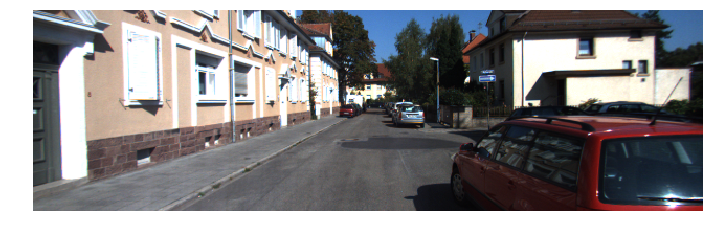

In [52]:
plot_img(imgs1, index)

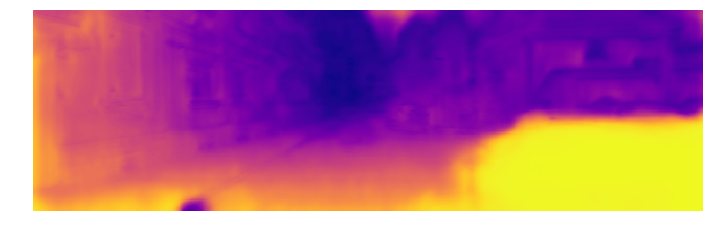

In [53]:
plot_depth(d2[0], index, scale=1, inv=False, cb=False, cmap='plasma')

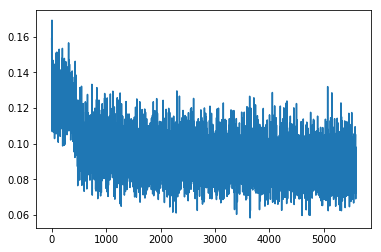

In [54]:
plot_losses(losses)

# Full Epochs Testing

In [ ]:
verbose = 500

In [ ]:
def train(m, opt, MD1, MD2, MD3, MDcam):
    DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
    losses = []  

    for i in range(len(MD1.trn_ds)//bs-len(losses)):
        opt.zero_grad()
        imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])

        d1, d2, d3, trans, rotation, = m(imgs1, imgs2, imgs3)

        imgs1, imgs2, imgs3 = denorm(imgs1, volatile=True), denorm(imgs2, volatile=True), denorm(imgs3, volatile=True)

#         imgs1, imgs2, imgs3 = denorm(imgs1, imgnet_mean, imgnet_std), denorm(imgs2, imgnet_mean, imgnet_std), denorm(imgs3, imgnet_mean, imgnet_std) 

        loss, details = l(d1, d2, d3, trans, rotation, imgs1, imgs2, imgs3, cam)
        loss.backward()
        opt.step()
        losses.append(loss.data[0])
        # appr smooth ssim l1
        if i%verbose == 0: print(loss.data[0],
                                 details[0].data[0],
                                 details[1].data[0],
                                 details[2].data[0],
                                 details[3].data[0],
                                 sep='\t')
    return losses

In [ ]:
def fit(epoch, m, opt, MD1, MD2, MD3, MDcam):
    for i in range(epoch):
        print("--------------------epoch {} start:----------------------".format(i))
        losses = train(m, opt, MD1, MD2, MD3, MDcam)
        losses= [ str(loss) for loss in losses ]
        folder = Path("./tmp")
        folder.mkdir(exist_ok=True)
        file = folder / 'epoch{}.log'.format(i)
        with file.open('w') as f:
            f.write("\n".join(losses))
        save_model(m, str(folder / "epoch{}.M".format(i)))

In [ ]:
fit(5, m, opt, MD1, MD2, MD3, MDcam)

In [ ]:
from fastai.torch_imports import save_model, load_model

In [ ]:
MODEL_PATH = "./TriDepth_test1.M"

In [ ]:
save_model(m, MODEL_PATH)

In [ ]:
load_model(m, MODEL_PATH)

In [ ]:
ls -l *.M

verbose = 20
def fit(model, metric, opt, MD1, MD2, MD3, MDcam):
    DL1, DL2, DL3, DLcam = iter(MD1.trn_dl), iter(MD2.trn_dl), iter(MD3.trn_dl), iter(MDcam.trn_dl)
    losses = []
    for i in range(len(MD1.trn_ds)//bs):
        opt.zero_grad()
        imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])
        
        d1, d2, d3, poses_x2 = m(imgs1, imgs2, imgs3)
        loss, details = l(d1, d2, d3, poses_x2, imgs1, imgs2, imgs3, cam)
        loss.backward()
        opt.step()
        losses.append(loss.data[0])
        if i%verbose == 0: print(loss.data[0],
                                 details[0].data[0],
                                 details[1].data[0],
                                 details[2].data[0],
                                 details[3].data[0],
                                 sep='\t')
    return A(loesses).mean()

fit(m, l, opt, MD1, MD2, MD3, MDcam)

In [ ]:
DL1, DL2, DL3, DLcam = iter(MD1.val_dl), iter(MD2.val_dl), iter(MD3.val_dl), iter(MDcam.val_dl)

In [ ]:
imgs1, imgs2, imgs3, cam = V([next(DL1), next(DL2),next(DL3), next(DLcam)[1]])

In [ ]:
d1s, d2s, d3s, transistion, rotation = m(imgs1, imgs2, imgs3)

imgs1, imgs2, imgs3 = denorm(imgs1, volatile=True), denorm(imgs2, volatile=True), denorm(imgs3, volatile=True)
#imgs1, imgs2, imgs3 = denorm(imgs1, imgnet_mean, imgnet_std), denorm(imgs2, imgnet_mean, imgnet_std), denorm(imgs3, imgnet_mean, imgnet_std) 


In [ ]:
i = 0
d2 = d2s[i]
if d3s[0] is not None:
    d3 = d3s[i]
if d1s[0] is not None:
    d1 = d1s[i]
#d1, d2, d3 = d1s[0], d2s[0], d3s[0]

In [ ]:
if i>0: d2 = F.upsample(input=d2, scale_factor=2**i, mode='bilinear')
if i>0 and d1[0] is not None: d1 = F.upsample(input=d1, scale_factor=2**i, mode='bilinear')
if i>0 and d3[0] is not None : d3 = F.upsample(input=d3, scale_factor=2**i, mode='bilinear')

if l.appr.warp_setting[0]:
    x21, mask21 = l.appr.warp(imgs2,transistion[:, 0], rotation[:, 0], d1, cam, reverse=True)
if l.appr.warp_setting[1]:
    x12, mask12 = l.appr.warp(imgs1,transistion[:, 0], rotation[:, 0], d2, cam, reverse=False)
if l.appr.warp_setting[2]:    
    x32, mask32 = l.appr.warp(imgs3,transistion[:, 1], rotation[:, 1], d2, cam, reverse=False)
if l.appr.warp_setting[3]:
    x23, mask23 = l.appr.warp(imgs2,transistion[:, 1], rotation[:, 1], d3, cam, reverse=True)


In [ ]:
transistion.shape, rotation.shape

In [ ]:
transistion[0,0]

In [ ]:
rotation[0,0]

In [ ]:
transistion[0,1]

In [ ]:
rotation[0,1]

def plot_depth(depth, index=0, figsize=(12,4), scale=50, inv=True, cb=True, cmap='plasma'):
    inv_depth = depth.cpu().data[index].numpy()
    inv_depth = np.clip(inv_depth, a_min=0.01, a_max=None)
    if inv:
        depth = 1/inv_depth[0]
    else:
        depth = inv_depth[0]
        
    m, std, mx = depth.mean(axis=(0, 1)), depth.std(axis=(0, 1)), depth.max(axis=(0, 1))
    plt.figure(figsize=figsize)
    plt.imshow(
        depth*scale,
        cmap=cmap,
        #vmin=max(m - 2*std, 0),
        #vmax=min(m+2*std, mx)
    )
    if cb: plt.colorbar()
    plt.axis('off')

def plot_img(recon, index=0, figsize=(12,4)):
    #recon = MD1.trn_ds.denorm(recon)[index]
    recon = recon[index].cpu().permute(1,2,0).data.numpy()
    print(recon.min(), recon.max())
    plt.figure(figsize=figsize)
    plt.imshow(recon)
    plt.axis('off')    

def plot_mask(mask, index=0, figsize=(12,4)):
    plt.style.use('grayscale')
    mask = mask[index]
    plt.figure(figsize=figsize)
    plt.imshow(mask.cpu().data.numpy(),cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.axis('off')

In [ ]:
index = 3

In [ ]:
plot_img(imgs1, index)

In [ ]:
plot_img(imgs2, index)

In [ ]:
plot_img(imgs3, index)

In [ ]:
plot_img(x12, index)

In [ ]:
plot_img(x32, index)

In [ ]:
plot_img(x21, index)

In [ ]:
plot_img(x23, index)

In [ ]:
npd2 = 1/(d2.cpu() + 0.01).data.numpy()

In [ ]:
npd2.mean(), npd2.std(), npd2.min(), npd2.max()

In [ ]:
plot_depth(d1, index, scale=1, inv=False, cb=False, cmap='plasma')

In [ ]:
plot_depth(d2, index, scale=1, inv=False, cb=False, cmap='plasma')

In [ ]:
plot_depth(d3, index, scale=1, inv=False, cb=False, cmap='plasma')

In [ ]:
imgs1[0].mean(), imgs1[0].std()

In [ ]:
d2[0].mean(), d2[0].std()

In [ ]:
ssim_loss(imgs1, imgs2, V(torch.ones_like(imgs1)))

In [ ]:
l1_loss(imgs1, imgs2, V(torch.ones_like(imgs1)))